In [1]:
setwd('..')

## Daily Cases by Colorado County

In [2]:
# helper functions for computing LQ and rates
source('code/support_functions.R')

In [3]:
## fetch any new case files
# will skip download if no new files are available
source('code/get_new_case_data.R')

Using an auto-discovered, cached token.
To suppress this message, modify your code or options to clearly consent to the use of a cached token.
See gargle's "Non-interactive auth" vignette for more details:
https://gargle.r-lib.org/articles/non-interactive-auth.html
The googledrive package is using a cached token for jotu9073@colorado.edu.


No new case data files available.



County population counts are also based on ACS 5-year estimates for 2018 and were acquired from the [Social Explorer Database](https://socialexplorer.com).

In [4]:
## prep total population data
# county population (sex by age, aggregates to total county pop)
co_sxa <- read.csv('data/co_sex_by_age_by_county_acs_2018_5yr.csv',
                   stringsAsFactors = F) 

# subset the county ID and total population columns
co_pop <- co_sxa[,c('Geo_NAME', 'ACS18_5yr_B01001001')]

# rename total population column
names(co_pop)[2] <- 'pop'

In [5]:
# some of the earlier dates don't have the ` County` suffix,
# so remove this from the total population count IDs
co_pop$Geo_NAME <- gsub(' County', '', co_pop$Geo_NAME)

In [6]:
# all filenames in the `data` folder
data_files <- list.files('data')

In [7]:
# filenames for all covid19 case data files
covid_sf <- data_files[startsWith(data_files, 'covid19')]

In [8]:
## build daily case data
daily_cases_cty <- lapply(covid_sf, function(covx){
    
    # full path to the file
    path.covx <- file.path('data', covx)
    
    # extract date info from filename
    date.covx <- gsub('covid19_case_summary_', '', covx) # strip prefix
    date.covx <- gsub('.csv', '', date.covx) # strip file extension
    
    # read in file
    data.covx <- read.csv(path.covx, stringsAsFactors = F)
    
    # subset to counties
    cty.covx <- data.covx[data.covx$description == 'Case Counts by County' & data.covx$metric == 'Cases',] 
    
    # append date 
    cty.covx <- data.frame(date = date.covx, cty.covx, stringsAsFactors = F)
    
    # convert date from text to date/time
    cty.covx$date <- lubridate::date(cty.covx$date)
    
    # ensure `value` column is numeric
    cty.covx$value <- as.numeric(cty.covx$value)
    
    # strip `County` prefix if it exists 
    cty.covx$attribute <- gsub(' County', '', cty.covx$attribute)
    
    # append total population counts
    cty.covx <- merge(cty.covx, co_pop, by.x = 'attribute', by.y = 'Geo_NAME')
    
    # append location quotient and case rates
    cty.covx$lq <- lq(cty.covx)
    cty.covx$cases_100k <- rate(cty.covx)
    
    cty.covx[,c('attribute', 'date', 'value', 'pop', 'lq', 'cases_100k')]
    
})

In [9]:
# combine results into a single data frame
daily_cases_cty <- do.call(rbind, daily_cases_cty)

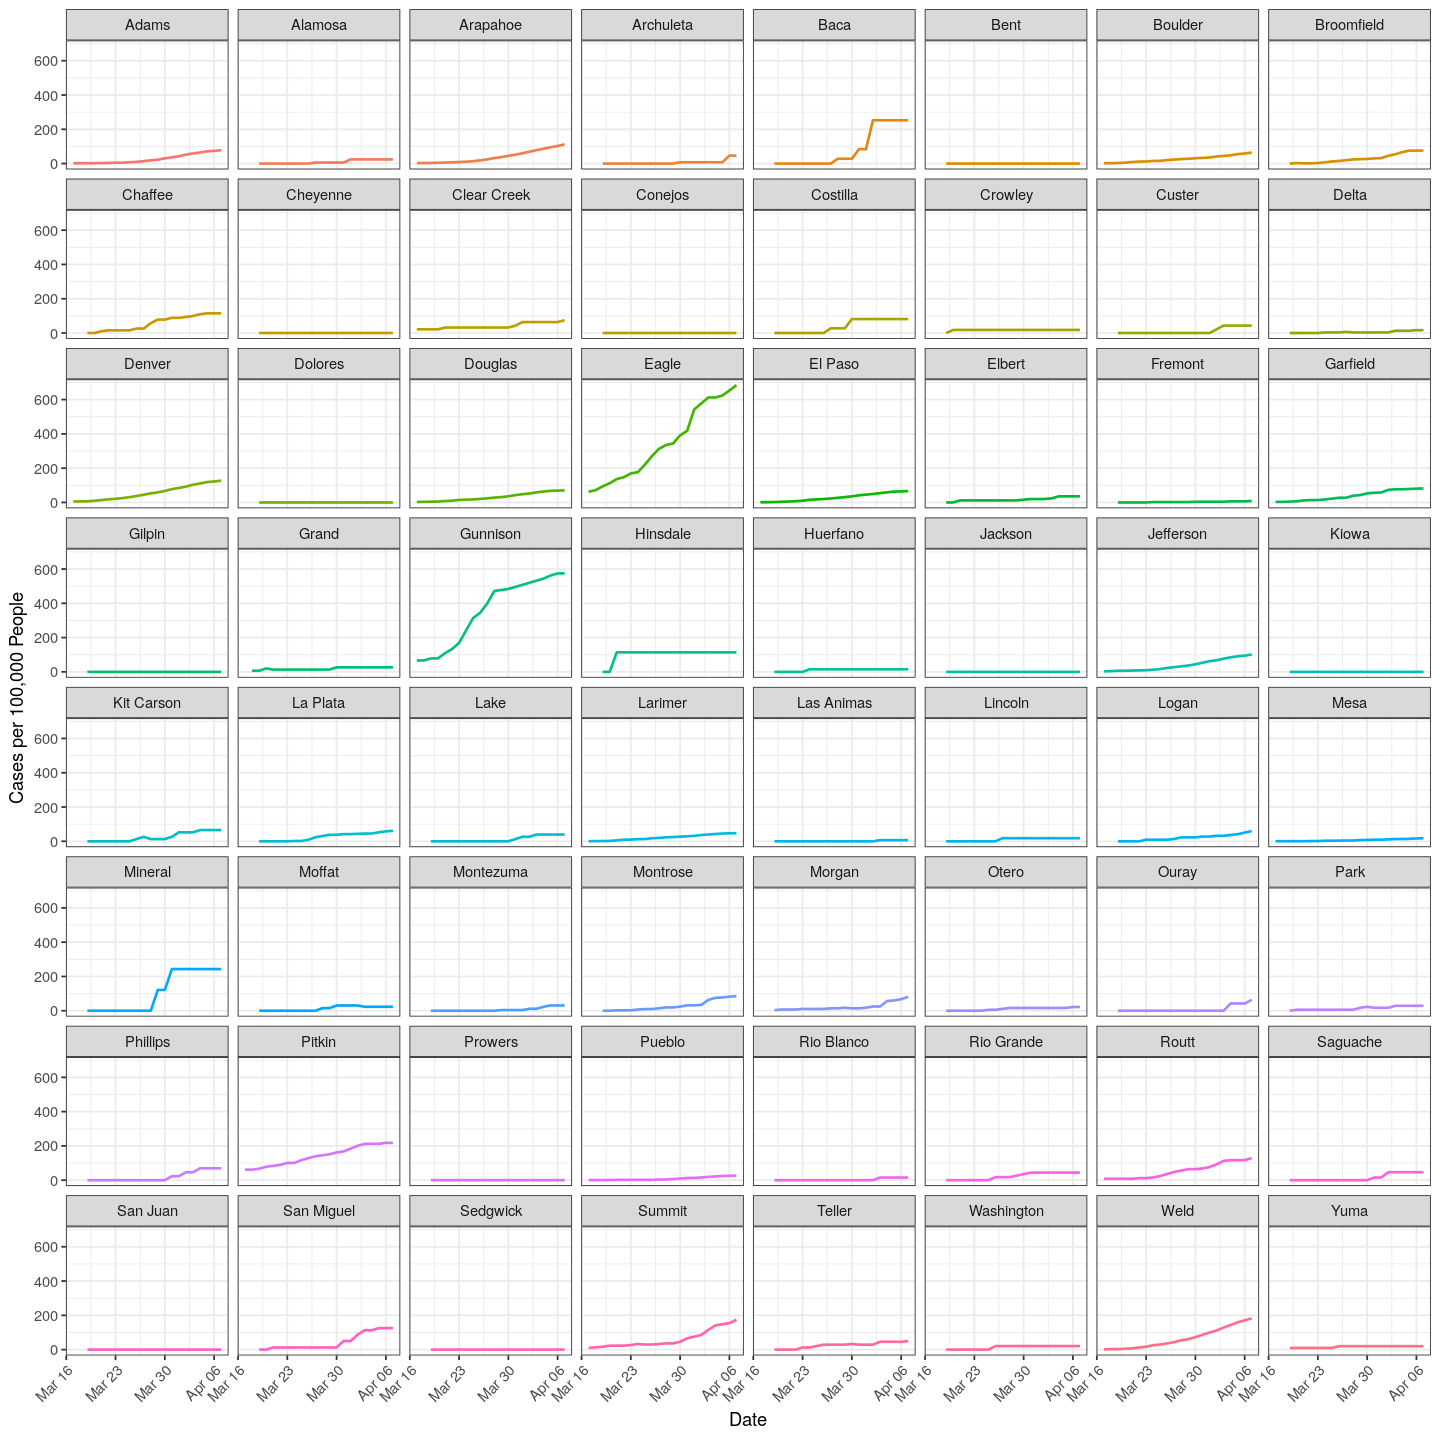

In [10]:
# plot results
library(ggplot2)
options(repr.plot.height = 12, repr.plot.width = 12)
ggplot(data = daily_cases_cty, aes(x = date, y = cases_100k, color = attribute)) + 
    geom_line(size = 0.75) +
    facet_wrap(~attribute) +
    xlab('Date') +
    ylab('Cases per 100,000 People') +
    theme_bw() +
    theme(axis.text.x = element_text(hjust = 1, angle = 45)) +
    theme(legend.position = 'none')

Warning message:
“Transformation introduced infinite values in continuous y-axis”


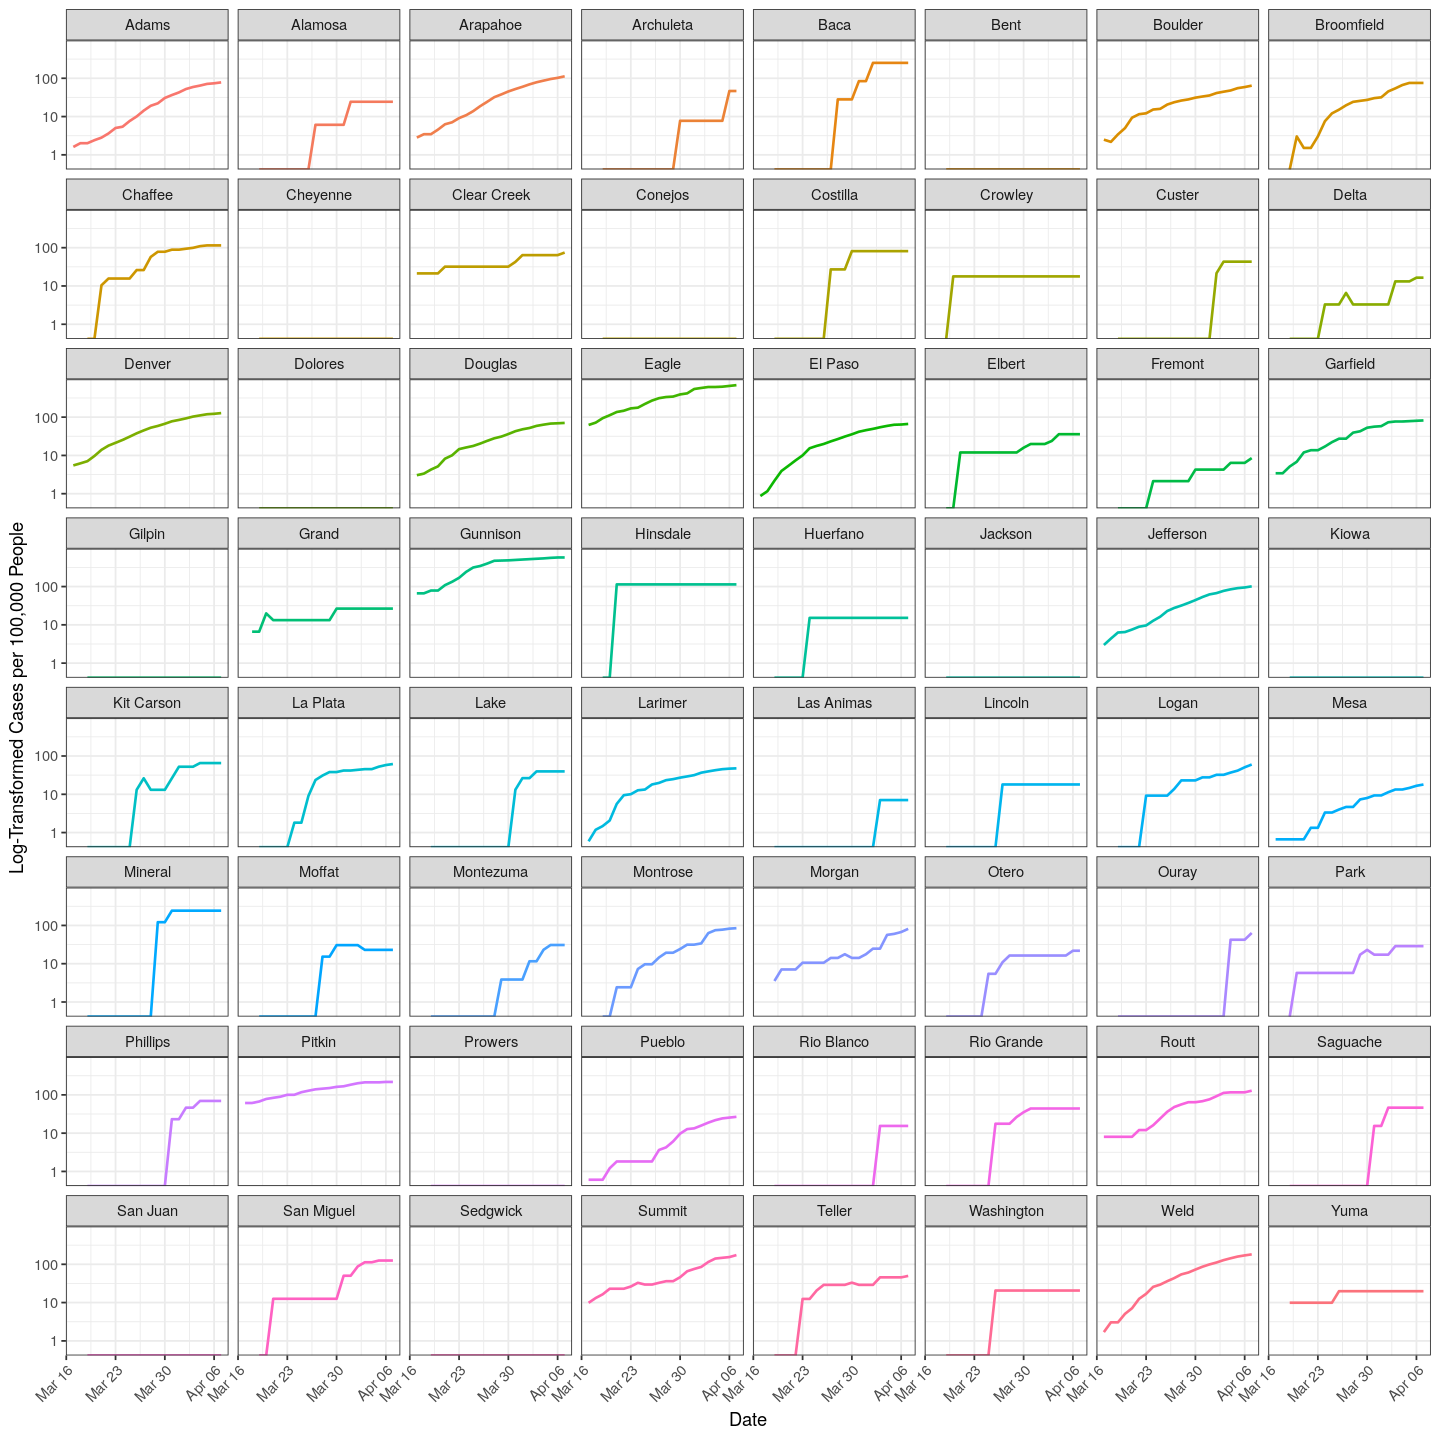

In [11]:
# with logarithmic y-axis
options(repr.plot.height = 12, repr.plot.width = 12)
ggplot(data = daily_cases_cty, aes(x = date, y = cases_100k, color = attribute)) + 
    geom_line(size = 0.75) +
    facet_wrap(~attribute) +
    scale_y_log10() +
    xlab('Date') +
    ylab('Log-Transformed Cases per 100,000 People') +
    theme_bw() +
    theme(axis.text.x = element_text(hjust = 1, angle = 45)) +
    theme(legend.position = 'none')

## County Clusters (Experimental)

In [12]:
library(classInt)

In [13]:
# convert daily cases back to list format
daily_cases_split <- split(daily_cases_cty, daily_cases_cty$date)

In [14]:
# need to remove 3/17 and 3/18
# since not all counties reporting
daily_cases_split <- daily_cases_split[-c(1:2)]

In [15]:
# daily breaks
k = 5
bx <- lapply(daily_cases_split, function(x){
        
    cut(x$cases_100k, 
        classIntervals(x$cases_100k,
                       style = 'jenks',
                       n = k)$brk,
#                        )$brk,
        include.lowest = T,
        )
#         labels = 1:k)
    
})

In [16]:
bx <- do.call(cbind, bx)
rownames(bx) <- sort(unique(daily_cases_cty$attribute))

In [17]:
d <- dist(bx, method = 'manhattan')
d <- as.matrix(d)

In [18]:
library(apcluster)
source('../felis/code/apcluster_helper.R')
apc <- apcluster(-d)
apc


Attaching package: ‘apcluster’


The following object is masked from ‘package:stats’:

    heatmap





APResult object

Number of samples     =  64 
Number of iterations  =  414 
Input preference      =  -13 
Sum of similarities   =  -131 
Sum of preferences    =  -130 
Net similarity        =  -261 
Number of clusters    =  10 

Exemplars:
   Baca Bent Boulder Crowley Eagle Hinsdale La Plata Pitkin Routt Saguache
Clusters:
   Cluster 1, exemplar Baca:
      Baca Mineral
   Cluster 2, exemplar Bent:
      Alamosa Archuleta Bent Cheyenne Conejos Delta Dolores Elbert Fremont 
      Gilpin Huerfano Jackson Kiowa Las Animas Lincoln Mesa Moffat Montezuma 
      Otero Park Prowers Pueblo Rio Blanco San Juan Sedgwick Washington
   Cluster 3, exemplar Boulder:
      Boulder Clear Creek Douglas El Paso Garfield Larimer Teller
   Cluster 4, exemplar Crowley:
      Crowley Grand Yuma
   Cluster 5, exemplar Eagle:
      Eagle Gunnison
   Cluster 6, exemplar Hinsdale:
      Hinsdale
   Cluster 7, exemplar La Plata:
      Adams Broomfield Costilla Kit Carson La Plata Logan Montrose Rio Grande
   Clu

In [19]:
# load county boundaries
library(sf)
counties <- read_sf('data', 'cb_2018_us_county_500k')
counties <- counties[counties$STATEFP == '08',]
counties <- counties[match(rownames(bx), counties$NAME),]

Linking to GEOS 3.5.1, GDAL 2.1.2, PROJ 4.9.3



Cannot open layer cb_2018_us_county_500k


ERROR: Error in CPL_read_ogr(dsn, layer, query, as.character(options), quiet, : Opening layer failed.



In [ ]:
# assign cluster labels
counties['cluster'] <- factor(clust_vec(apc))

In [ ]:
plot(counties['cluster'], lwd = 0.1)

### Version 2 - Ensemble clustering

In [90]:
day1 <- daily_cases_split[[(length(daily_cases_split) - 1)]] # 4/6
# day1 <- daily_cases_split[[12]] 

In [91]:
day2 <- daily_cases_split[[length(daily_cases_split)]] # 4/7
# day2 <- daily_cases_split[[13]]

In [92]:
rate_of_change <- (day2$cases_100k - day1$cases_100k)
# rate_of_change <- rate_of_change / day1$cases_100k
rate_of_change[is.na(rate_of_change)] <- 0

In [93]:
head(day2[order(rate_of_change, decreasing = T),])

,attribute,date,value,pop,lq,cases_100k
,<chr>,<date>,<dbl>,<int>,<dbl>,<dbl>
1273,Eagle,2020-04-07,372,54357,7.3117953,684.36448
1300,Ouray,2020-04-07,3,4722,0.6787844,63.53240
1313,Summit,2020-04-07,53,30429,1.8609074,174.17595
1298,Morgan,2020-04-07,23,28257,0.8696377,81.39576
1308,Routt,2020-04-07,32,24874,1.3744879,128.64839
1316,Weld,2020-04-07,537,295123,1.9440516,181.95803


In [94]:
inx <- scale(cbind(rate_of_change, day2$cases_100k))
rownames(inx) <- day2$attribute

In [95]:
apcx <- apcluster(negDistMat(inx))

In [96]:
apcx


APResult object

Number of samples     =  64 
Number of iterations  =  138 
Input preference      =  -0.7553865 
Sum of similarities   =  -7.34749 
Sum of preferences    =  -9.820025 
Net similarity        =  -17.16752 
Number of clusters    =  13 

Exemplars:
   Broomfield Chaffee Denver Eagle Gunnison La Plata Logan Mineral Ouray 
   Rio Blanco Rio Grande Routt Summit
Clusters:
   Cluster 1, exemplar Broomfield:
      Broomfield Costilla Douglas Garfield Kit Carson Phillips
   Cluster 2, exemplar Chaffee:
      Chaffee Hinsdale San Miguel
   Cluster 3, exemplar Denver:
      Denver Jefferson
   Cluster 4, exemplar Eagle:
      Eagle
   Cluster 5, exemplar Gunnison:
      Gunnison
   Cluster 6, exemplar La Plata:
      Adams Boulder El Paso La Plata Montrose Teller
   Cluster 7, exemplar Logan:
      Clear Creek Logan
   Cluster 8, exemplar Mineral:
      Baca Mineral Pitkin
   Cluster 9, exemplar Ouray:
      Ouray
   Cluster 10, exemplar Rio Blanco:
      Alamosa Bent Cheyenne Cone

In [97]:
clustx <- clust_vec(apcx)

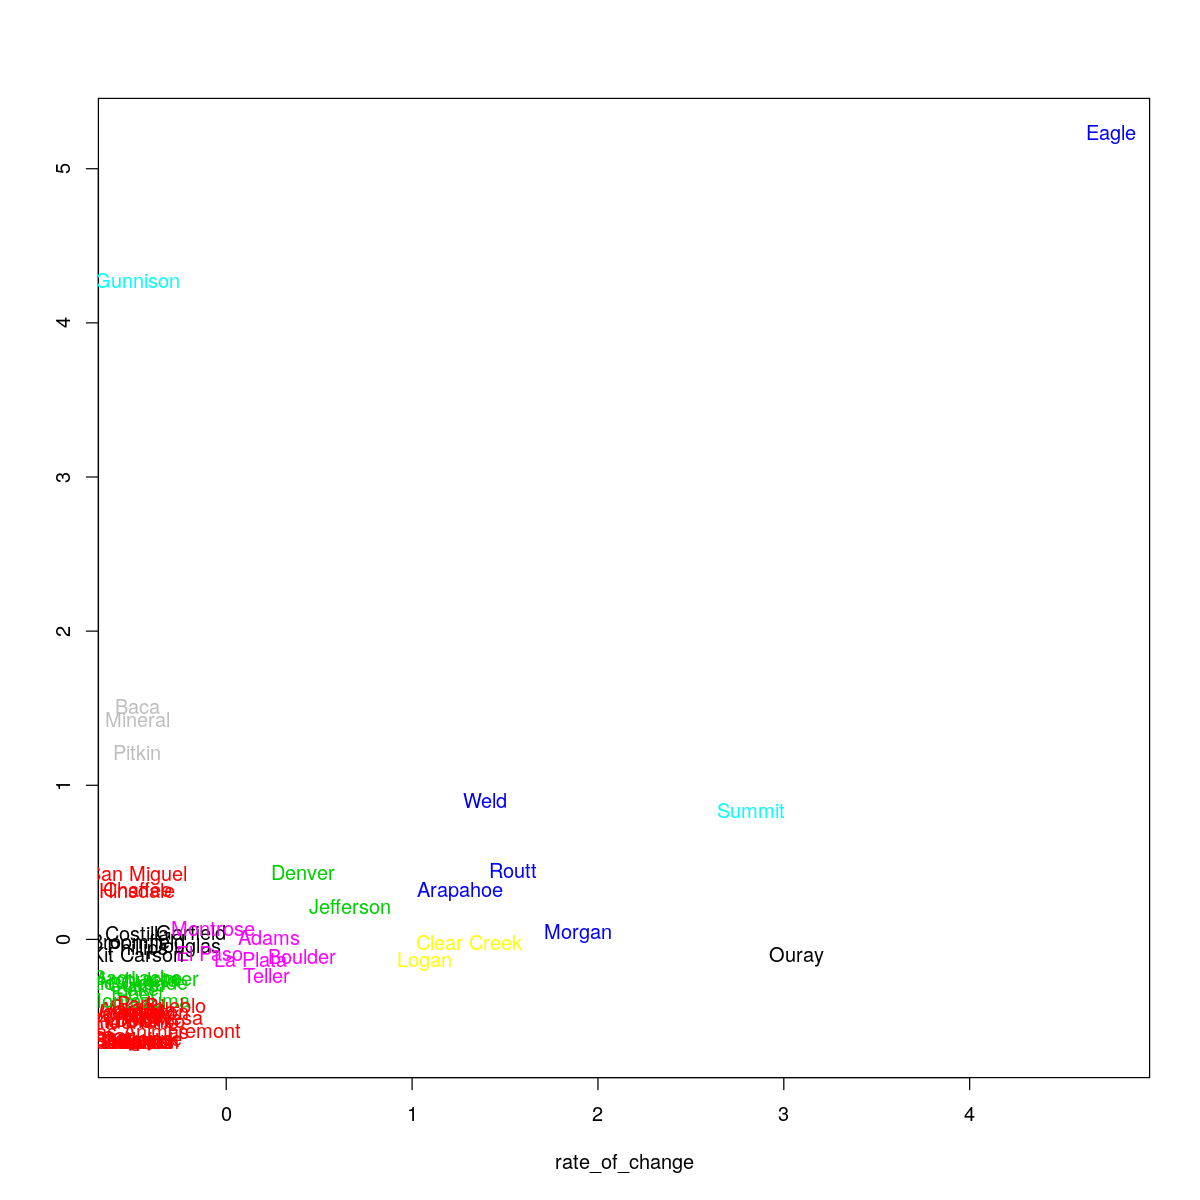

In [98]:
options(repr.plot.height = 10, repr.plot.width = 10)
text(inx, 
     plot(inx, cex = 0),
     labels = day2$attribute,
    col = clustx)

#### Full ensemble

In [101]:
ens <- sapply(3:length(daily_cases_split), function(i){
    
    day1 <- daily_cases_split[[i-1]]
    day2 <- daily_cases_split[[i]]
    
    rate_of_change <- (day2$cases_100k - day1$cases_100k)
    rate_of_change[is.na(rate_of_change)] <- 0
    
    inx <- scale(cbind(rate_of_change, day2$cases_100k))
    rownames(inx) <- day2$attribute
    
    apcx <- apcluster(negDistMat(inx))
    
    clustx <- clust_vec(apcx)
    names(clustx) <- rownames(inx)
    clustx
    
})

In [105]:
ed <- vegan::vegdist(ens)
es <- 1 - as.matrix(ed)

In [112]:
round(sort(es['Boulder',], decreasing = T), 2)

Boulder     Larimer   Jefferson     El Paso       Logan      Teller 
       1.00        0.90        0.82        0.80        0.78        0.77 
    Douglas    Gunnison    Garfield    La Plata      Summit      Elbert 
       0.77        0.76        0.76        0.76        0.76        0.75 
      Grand       Routt        Yuma      Pitkin     Chaffee       Eagle 
       0.75        0.73        0.72        0.72        0.71        0.71 
     Morgan  San Miguel     Crowley      Denver  Broomfield    Hinsdale 
       0.70        0.70        0.70        0.70        0.68        0.67 
   Montrose     Mineral       Adams     Fremont    Huerfano Clear Creek 
       0.66        0.66        0.66        0.66        0.66        0.65 
   Arapahoe       Delta      Moffat   Montezuma      Pueblo  Las Animas 
       0.65        0.65        0.65        0.64        0.64        0.64 
       Bent    Cheyenne     Conejos     Dolores      Gilpin     Jackson 
       0.63        0.63        0.63        0.63        0.63        0.63 
      Kiowa     Prowers    San Juan    Sedgwick        Mesa      Custer 
       0.63        0.63        0.63        0.63        0.63        0.63 
   Saguache     Alamosa  Rio Grande     Lincoln        Park   Archuleta 
       0.63        0.62        0.62        0.62        0.62        0.62 
 Rio Blanco  Washington  Kit Carson    Phillips       Ouray        Weld 
       0.62        0.60        0.60        0.60        0.60        0.59 
       Lake    Costilla       Otero        Baca 
       0.59        0.59        0.58        0.55

In [113]:
apce <- apcluster(es)

In [114]:
apce


APResult object

Number of samples     =  64 
Number of iterations  =  213 
Input preference      =  0.6689273 
Sum of similarities   =  47.90951 
Sum of preferences    =  6.689273 
Net similarity        =  54.59879 
Number of clusters    =  10 

Exemplars:
   Boulder Broomfield Conejos Crowley El Paso Gunnison Lincoln Rio Blanco 
   Saguache Weld
Clusters:
   Cluster 1, exemplar Boulder:
      Boulder Larimer
   Cluster 2, exemplar Broomfield:
      Adams Broomfield
   Cluster 3, exemplar Conejos:
      Archuleta Bent Cheyenne Conejos Dolores Fremont Gilpin Jackson Kiowa 
      Las Animas Prowers San Juan Sedgwick
   Cluster 4, exemplar Crowley:
      Chaffee Crowley Elbert Grand Huerfano Logan Morgan Pitkin Routt 
      San Miguel Summit Teller Yuma
   Cluster 5, exemplar El Paso:
      Arapahoe Clear Creek Douglas El Paso Garfield Jefferson
   Cluster 6, exemplar Gunnison:
      Eagle Gunnison Hinsdale
   Cluster 7, exemplar Lincoln:
      Alamosa Kit Carson La Plata Lincoln Mesa M

In [116]:
# load county boundaries
library(sf)
counties <- read_sf('data', 'cb_2018_us_county_500k')
counties <- counties[counties$STATEFP == '08',]
counties <- counties[match(rownames(bx), counties$NAME),]

In [119]:
# assign cluster labels
counties['cluster'] <- factor(clust_vec(apce))

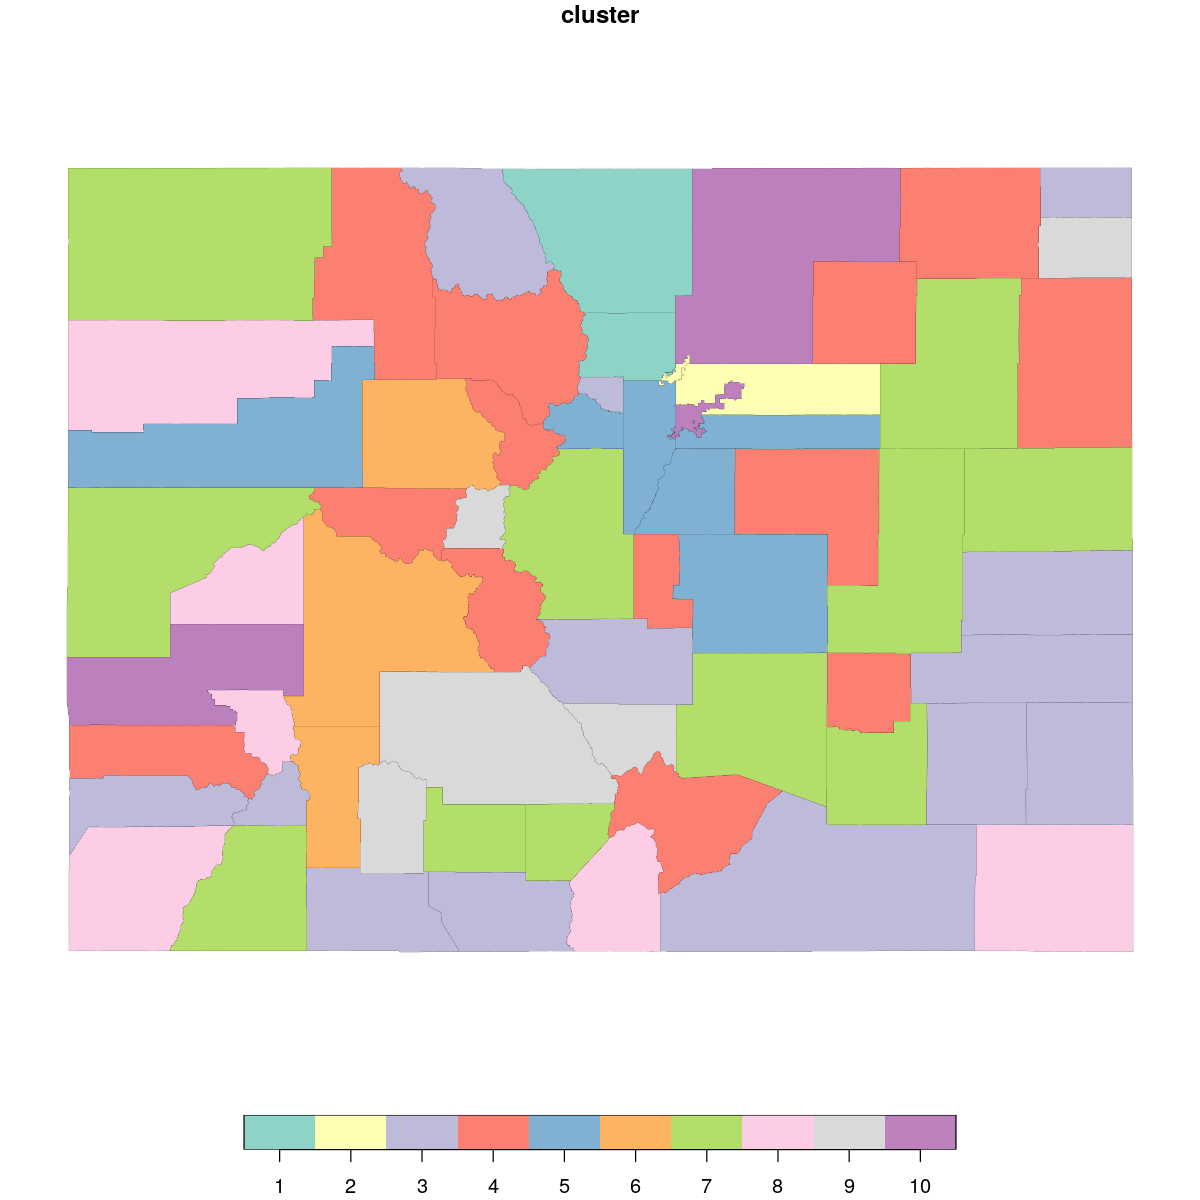

In [120]:
plot(counties['cluster'], lwd = 0.1)

Warning message:
“Transformation introduced infinite values in continuous y-axis”
`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Removed 437 rows containing non-finite values (stat_smooth).”


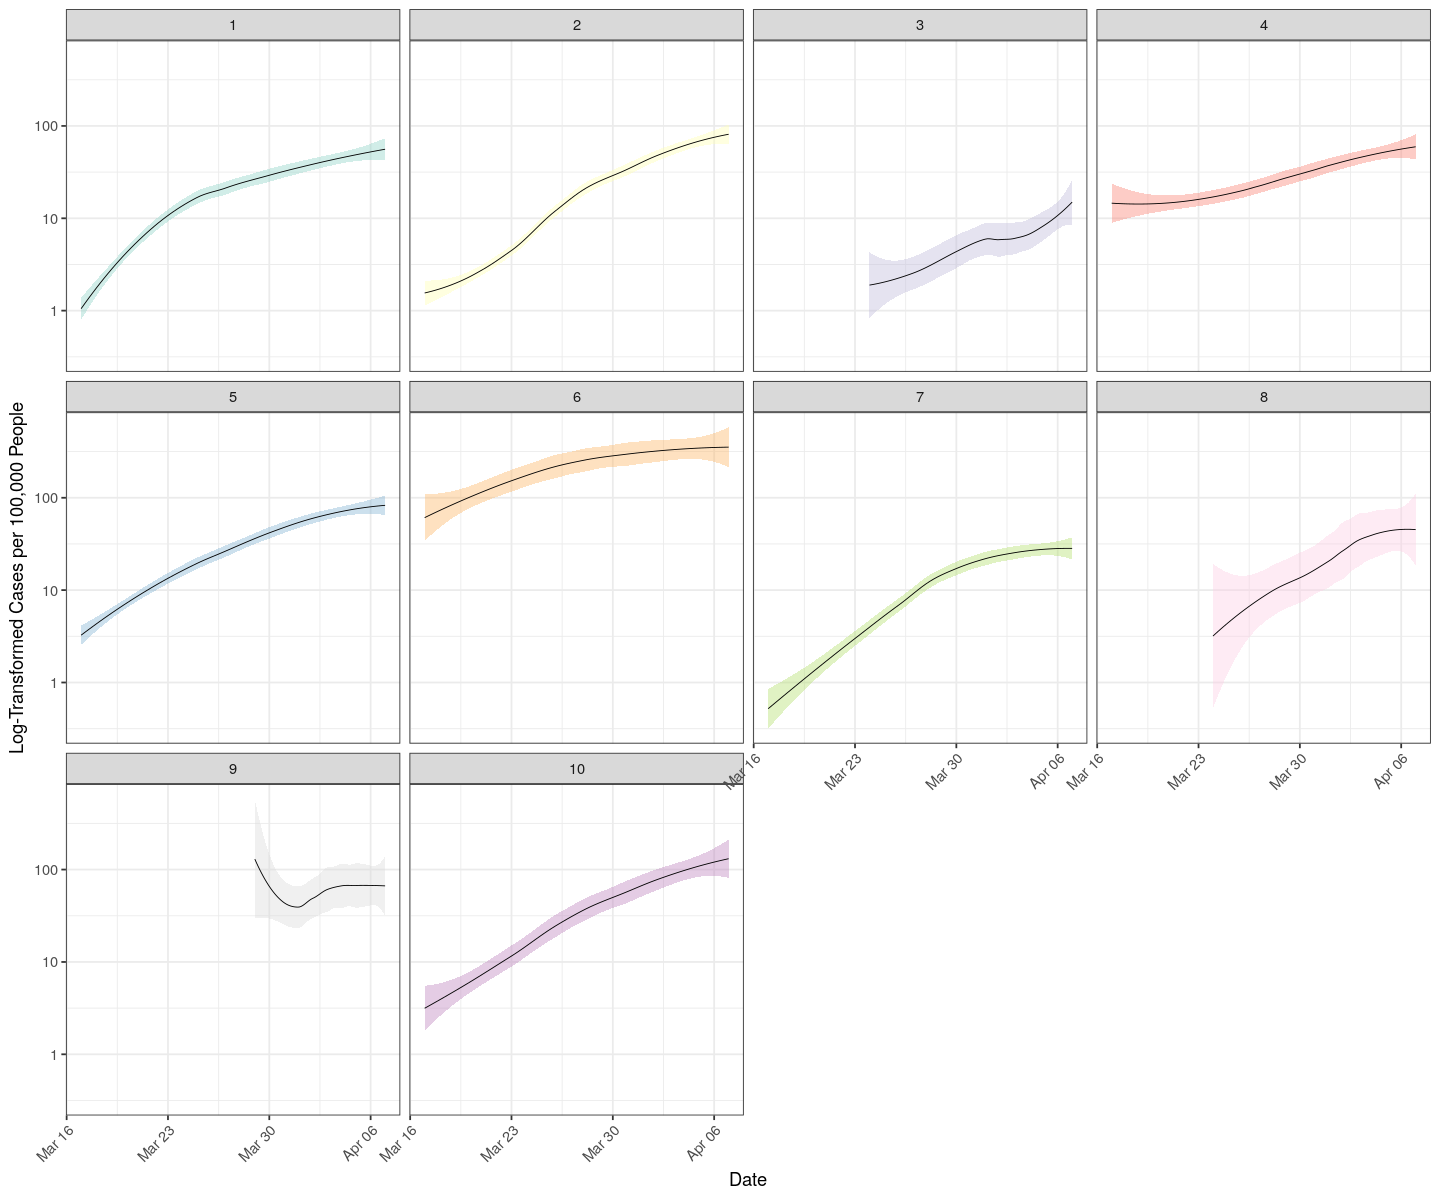

In [145]:
# with logarithmic y-axis
options(repr.plot.height = 10, repr.plot.width = 12)
ggplot(data = daily_cases_cty, aes(x = date, y = cases_100k, fill = cluster)) + 
    geom_smooth(color = 'black', size = 0.25) +
#     geom_line(size = 0.75) +
#     scale_color_brewer(type = 'qual', palette = 'Set3') +
    scale_fill_brewer(type = 'qual', palette = 'Set3') +
    facet_wrap(~cluster) +
    scale_y_log10() +
    xlab('Date') +
    ylab('Log-Transformed Cases per 100,000 People') +
    theme_bw() +
    theme(axis.text.x = element_text(hjust = 1, angle = 45)) +
    theme(legend.position = 'none')

In [126]:
library(smacof)
library(RColorBrewer)

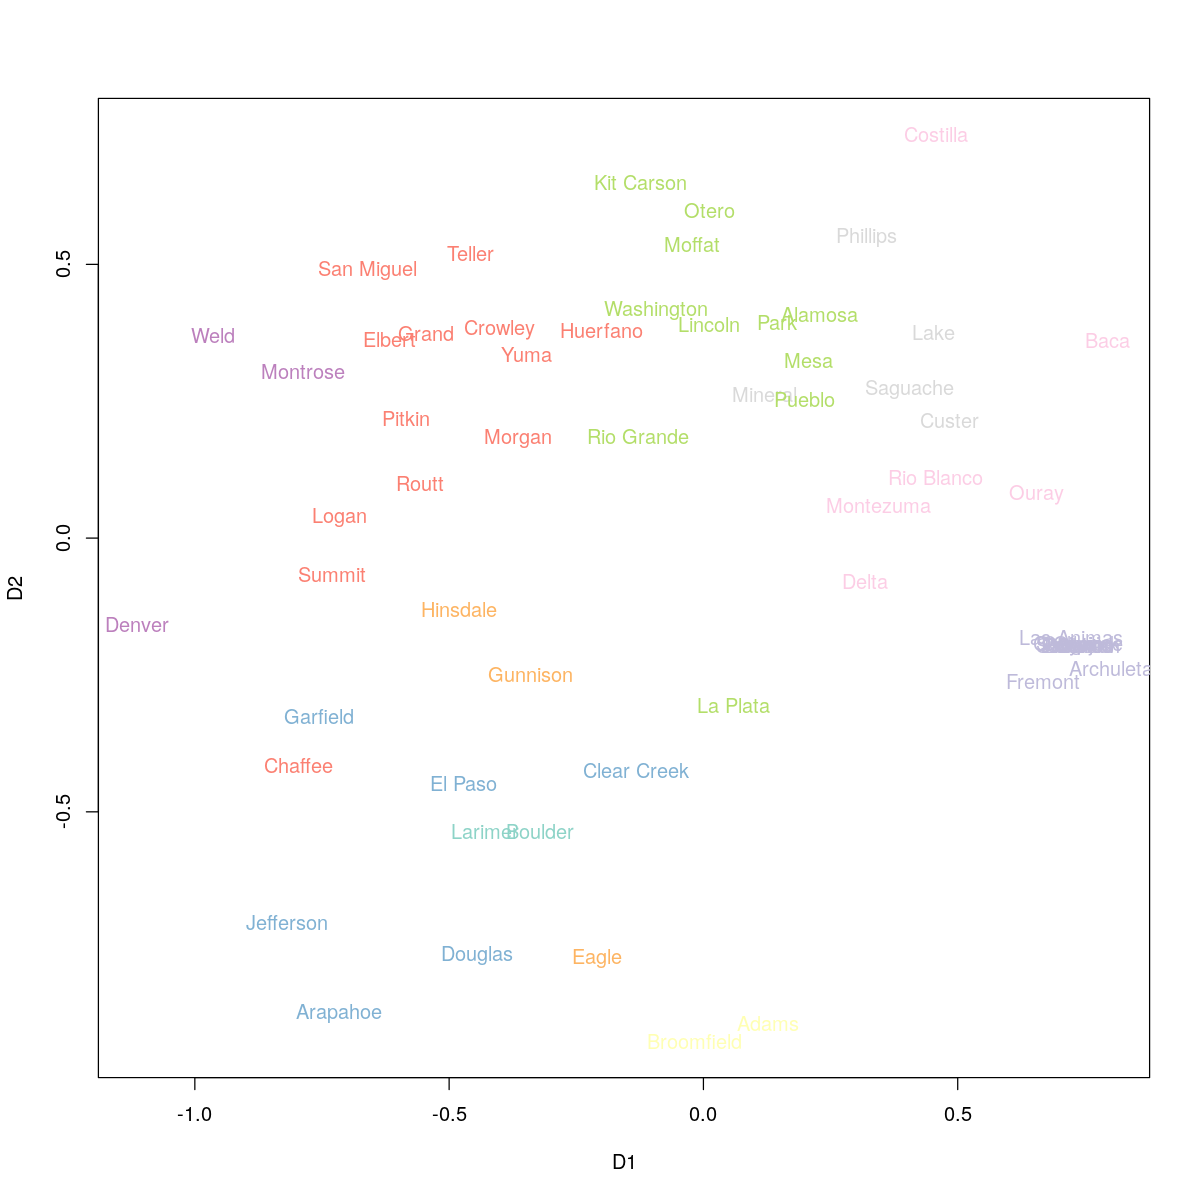

In [128]:
sm <- smacofSym(ed)
text(sm$conf, plot(sm$conf, cex = 0), 
     labels = counties$NAME,
     col = brewer.pal(10, 'Set3')[as.numeric(counties$cluster)])

In [131]:
daily_cases_cty$cluster <- counties$cluster[match(daily_cases_cty$attribute, counties$NAME)]